<a href="https://colab.research.google.com/github/shghatge/Robotics/blob/master/feature_set_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import nltk 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def dump_to_file(obj, file):
    f = open(file,"wb")
    pickle.dump(obj,f)
    f.close()

In [0]:
def get_obj(file):
    with open(file, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [0]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [0]:
clean_file_train = 'Top10Train.csv'
clean_file_test = 'Top10Test.csv'

In [25]:
trainFile = pd.read_csv(clean_file_train, low_memory=False)
testFile = pd.read_csv(clean_file_test, low_memory=False)
print('Data Read')

Data Read


In [26]:
print(trainFile["cleanText"][10])
print(trainFile["text"][10])
print(trainFile["fillers"][10])


 I uh my sister has a she just had a baby 
[ [ I, + {F uh, } my sister has a, ] + she just had a ] baby,  /
F 


In [0]:
corpus = list()
for index, row in trainFile.iterrows():
    curTxt = tokenize(row["cleanText"])
    corpus.append(' '.join(curTxt))

In [28]:
train_corpus = corpus
print(train_corpus[:10])


['doe it say someth', 'I think it usual doe', 'okay', 'well', 'okay', 'I', 'It seem like it did', 'but it might not', 'I guess', 'okay']


In [0]:
corpus = list()
for index, row in testFile.iterrows():
    corpus.append(' '.join(tokenize(row["cleanText"])))

In [0]:
test_corpus = corpus
corpus = []

In [31]:
print(test_corpus[:10])

['Uh huh', 'well um I we just recent graduat from rice univers', 'and uh we were go through a lot of job interview and thing', 'and some of the thing that were import to me uh when my husband wa look for hi job wa um hour you know', 'we', 'hed been in graduat school so I wa use to hi not be home at all', 'yeah', '', 'So I wa you know didnt want him to have a job that would make him kind of be on call all the time and have to go in at ani time and', 'Uh huh']


In [32]:
#feature set 1 , word frequency
from sklearn.feature_extraction.text import CountVectorizer
# create the transform
vectorizer = CountVectorizer(min_df = 40, max_df=1000000, tokenizer=tokenize)
# tokenize and build vocab
vectorizer.fit(train_corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1000000, max_features=None, min_df=40,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x7fdfa624ce18>, vocabulary=None)

In [33]:
print(len(vectorizer.vocabulary_))

1315


In [0]:
features_rows = dict()
for index , row in trainFile.iterrows():
    encoded = vectorizer.transform([row["cleanText"]])
    features_rows[index] = encoded.toarray()

In [0]:
train_labels = dict()
for index, row in trainFile.iterrows():
    train_labels[index] = row['act_tag']

In [36]:
print(type(features_rows[108]))

<class 'numpy.ndarray'>


In [0]:
unigram_file = 'train_features1.pkl'
labels_train_file = 'train_labels1.pkl'
unigram_test_file = 'test_features1.pkl'
labels_test_file = 'test_labels1.pkl'

In [0]:
features_rows = np.array([*features_rows.values()])[:,0,:]

In [0]:
train_labels = np.array([*train_labels.values()])

In [40]:
print(features_rows.shape)

(147510, 1315)


In [0]:
dump_to_file(features_rows, unigram_file)
dump_to_file(train_labels, labels_train_file)

In [0]:
x_train = get_obj(unigram_file)
y_train = get_obj(labels_train_file)

In [0]:
features_rows = dict()
test_labels = dict()

In [0]:
for index , row in testFile.iterrows():
    encoded = vectorizer.transform([row["cleanText"]])
    features_rows[index] = encoded.toarray()


In [45]:
test_labels = dict()
for index, row in testFile.iterrows():
    test_labels[index] = row['act_tag']
x_test = np.array([*features_rows.values()])
y_test = np.array([*test_labels.values()])
print(y_test.shape)

(26540,)


In [46]:
print(y_test.shape)

(26540,)


In [0]:
dump_to_file(x_test, unigram_test_file)
dump_to_file(y_test, labels_test_file)

In [0]:
x_test = get_obj(unigram_test_file)[:,0,:]
y_test = get_obj(labels_test_file)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier

In [0]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=50)).fit(x_train, y_train)

In [0]:
preds = model.predict(x_test)

In [52]:
print(len(preds))

26540


In [0]:
target_names = le.classes_

In [54]:
print(target_names)

['%' 'aa' 'b' 'ba' 'fc' 'ny' 'qy' 'sd' 'sv' 'x']


In [0]:
y_test = le.transform(y_test)

In [56]:
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

           %       0.58      0.72      0.64      2440
          aa       0.36      0.46      0.40       859
           b       0.85      0.95      0.90      6157
          ba       0.75      0.48      0.59       756
          fc       0.92      0.63      0.75       391
          ny       0.53      0.02      0.04       413
          qy       0.70      0.47      0.57       516
          sd       0.75      0.85      0.80     10287
          sv       0.64      0.32      0.42      4152
           x       0.82      1.00      0.90       569

   micro avg       0.73      0.73      0.73     26540
   macro avg       0.69      0.59      0.60     26540
weighted avg       0.73      0.73      0.71     26540



In [0]:
headers = vectorizer.get_feature_names()

In [0]:
pdf = pd.DataFrame(data=x_train,columns = headers) 
pdf.to_csv('Feature_Set_1_train')

In [0]:
pdf = pd.DataFrame(data=x_test,columns = headers) 
pdf.to_csv('Feature_Set_1_test')

Confusion matrix, without normalization
[[1761   38  146    8    2    2   18  371   58   36]
 [  34  394  380    4    1    4    1   29   10    2]
 [  71  214 5821   23    6    2    2    7    2    9]
 [  27  218   47  366    1    0   12   30   46    9]
 [  16    4   75    4  247    0    1   34    7    3]
 [   3   72  329    0    0    9    0    0    0    0]
 [  31    8   12    4    1    0  244  174   39    3]
 [ 761   63   20   20    6    0   42 8751  575   49]
 [ 358   84    2   60    5    0   27 2288 1312   16]
 [   0    0    0    0    0    0    0    0    0  569]]
Normalized confusion matrix
[[7.22e-01 1.56e-02 5.98e-02 3.28e-03 8.20e-04 8.20e-04 7.38e-03 1.52e-01
  2.38e-02 1.48e-02]
 [3.96e-02 4.59e-01 4.42e-01 4.66e-03 1.16e-03 4.66e-03 1.16e-03 3.38e-02
  1.16e-02 2.33e-03]
 [1.15e-02 3.48e-02 9.45e-01 3.74e-03 9.75e-04 3.25e-04 3.25e-04 1.14e-03
  3.25e-04 1.46e-03]
 [3.57e-02 2.88e-01 6.22e-02 4.84e-01 1.32e-03 0.00e+00 1.59e-02 3.97e-02
  6.08e-02 1.19e-02]
 [4.09e-02 1.02e-02 1

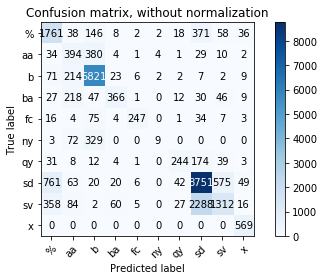

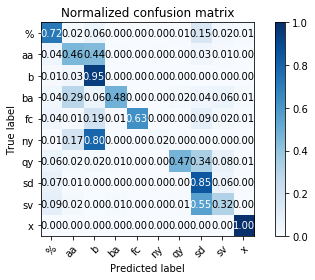

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, preds, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, preds, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [61]:
import matplotlib
print(matplotlib.matplotlib_fname())

/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/matplotlibrc


In [62]:
print(tokenize('think'))

['think']


In [63]:
len(x_train)

147510

In [0]:
wn = vectorizer.vocabulary_['think']

In [0]:
think_freq = x_train[:,wn]

In [66]:
print(le.classes_)

['%' 'aa' 'b' 'ba' 'fc' 'ny' 'qy' 'sd' 'sv' 'x']


In [0]:
row_tags = le.inverse_transform(y_test)

In [68]:
freq = [0] * 10
setences = [0] * 10
print(len(think_freq))

147510


In [0]:
for i in range(0,len(think_freq)):
    freq[y_train[i]]+= think_freq[i]
    setences[y_train[i]]+=1


In [0]:
weighted = [0] * 10
for i in range(0,10):
    weighted[i] = freq[i]/setences[i]

In [71]:
print(weighted)
print(setences)

[0.016872979578963967, 0.01835759287421247, 6.678465288676663e-05, 0.00480128034142438, 0.016595289079229122, 0.0, 0.04538531830642705, 0.03718025980982992, 0.19240788983997023, 0.0]
[12683, 9206, 29947, 3749, 1868, 2449, 3283, 59736, 21496, 3093]


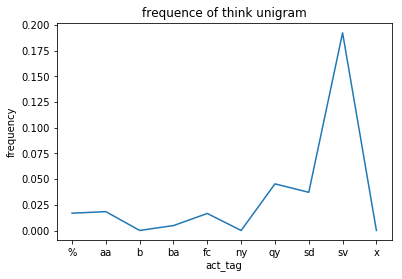

In [72]:
plt.plot(le.classes_, weighted)
plt.xlabel('act_tag')
plt.ylabel('frequency')
plt.title('frequence of think unigram')
plt.show()